In [1]:
cd ..

/Users/yanndubois/Desktop/GitHub/alpaca_eval


In [2]:

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'

from alpaca_eval import constants
import seaborn as sns
from alpaca_eval.plotting import save_fig, plot_benchmark_correlations, plot_config, show_new_lb, show_length_gameability, plot_heatmap_diff_baseline
import numpy as np

/Users/yanndubois/opt/anaconda3/envs/alpaca_eval/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_lb = pd.read_csv(constants.ALPACAEVAL_2_LEADERBOARD_PATHS / "weighted_alpaca_eval_gpt4_turbo_leaderboard.csv", index_col=0)

# Benchmark correlations

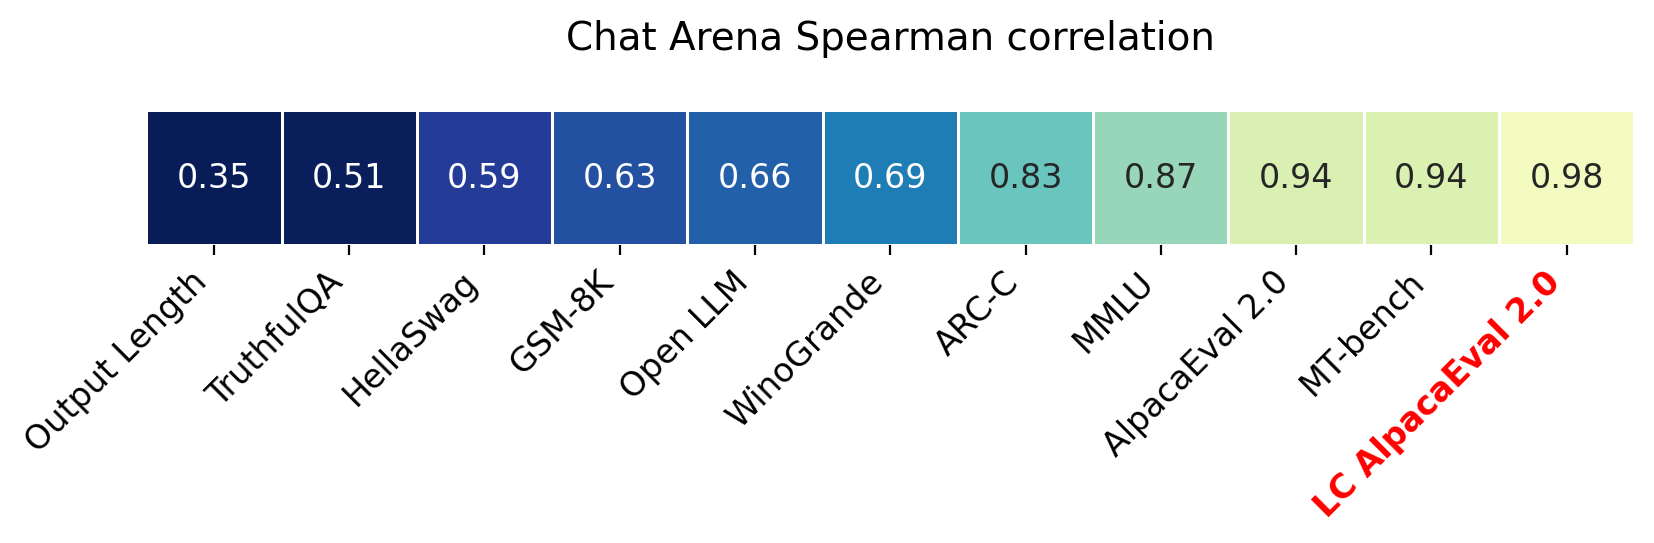

In [9]:
ax=plot_benchmark_correlations(is_only_arena=True, is_transpose=True, annot_kws=dict(fontsize=12), is_drop_alpaca=False) # cmap_name="coolwarm")
plt.gca().get_xticklabels()[-1].set_color('red')
plt.gca().get_xticklabels()[-1].set_fontweight('bold')
plt.show()
save_fig(ax, filename="figures/chat_correlations.png")

In [ ]:
ax=plot_benchmark_correlations(is_only_arena=True, is_transpose=True, annot_kws=dict(fontsize=12), is_drop_alpaca=True) # cmap_name="coolwarm")
plt.gca().get_xticklabels()[-1].set_color('red')
plt.gca().get_xticklabels()[-1].set_fontweight('bold')
save_fig(ax, filename="figures/chat_correlations_no_ae.png")

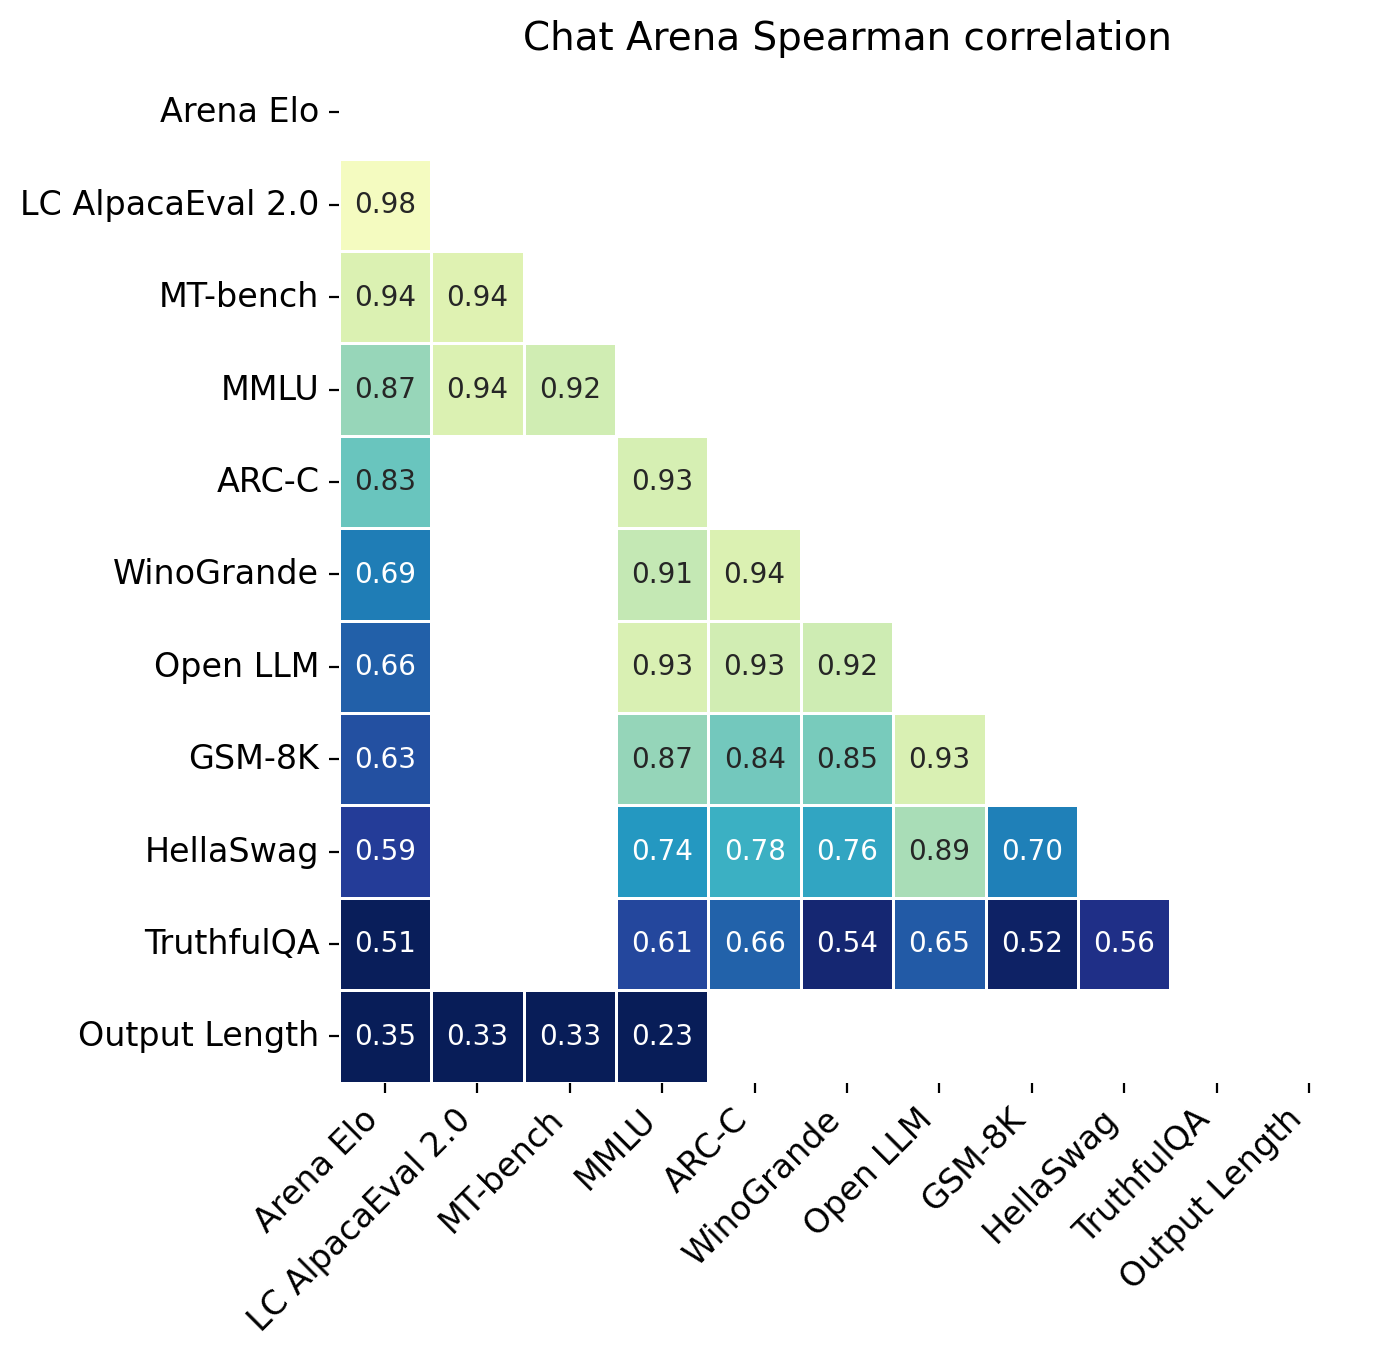

In [5]:
_=plot_benchmark_correlations(is_only_arena=False)

# Gameability

In [4]:
df_styled_gameability = show_length_gameability(df_lb)
df_styled_gameability

In [5]:
save_fig(df_styled_gameability, filename="figures/length_gameability.png", dpi=1000)

# Entire leaderboard

In [8]:
df_styled_lb = show_new_lb(df_lb.query("mode != 'dev'"), "length_controlled_winrate", n=15, n_tail=5)
df_styled_lb

,Length,Win Rate,New Win Rate,Win Rate Gain,Rank Gain
gpt4_1106_preview,2049,50.0,50.0,0.0,0
claude-3-opus-20240229,1388,29.0,40.4,11.4,5
gpt4,1365,23.6,38.1,14.6,8
Qwen1.5-72B-Chat,1549,26.5,36.6,10.1,5
gpt4_0314,1371,22.1,35.3,13.2,7
claude-3-sonnet-20240229,1420,25.6,34.9,9.3,4
mistral-large-2402,1362,21.4,32.7,11.2,10
Samba-CoE-v0.2-best-of-16,1578,27.0,31.5,4.5,0
gpt4_0613,1140,15.8,30.2,14.4,20
Snorkel-Mistral-PairRM-DPO-best-of-16,2616,34.9,30.0,-4.9,-8


In [9]:
save_fig(df_styled_lb, filename="figures/lc_ae_leaderboard.png", dpi=1000)

# Different baselines

In [4]:
n=9
models = list(df_lb.sort_values(by="length_controlled_winrate", ascending=False).query("mode != 'dev'").head(n).index)

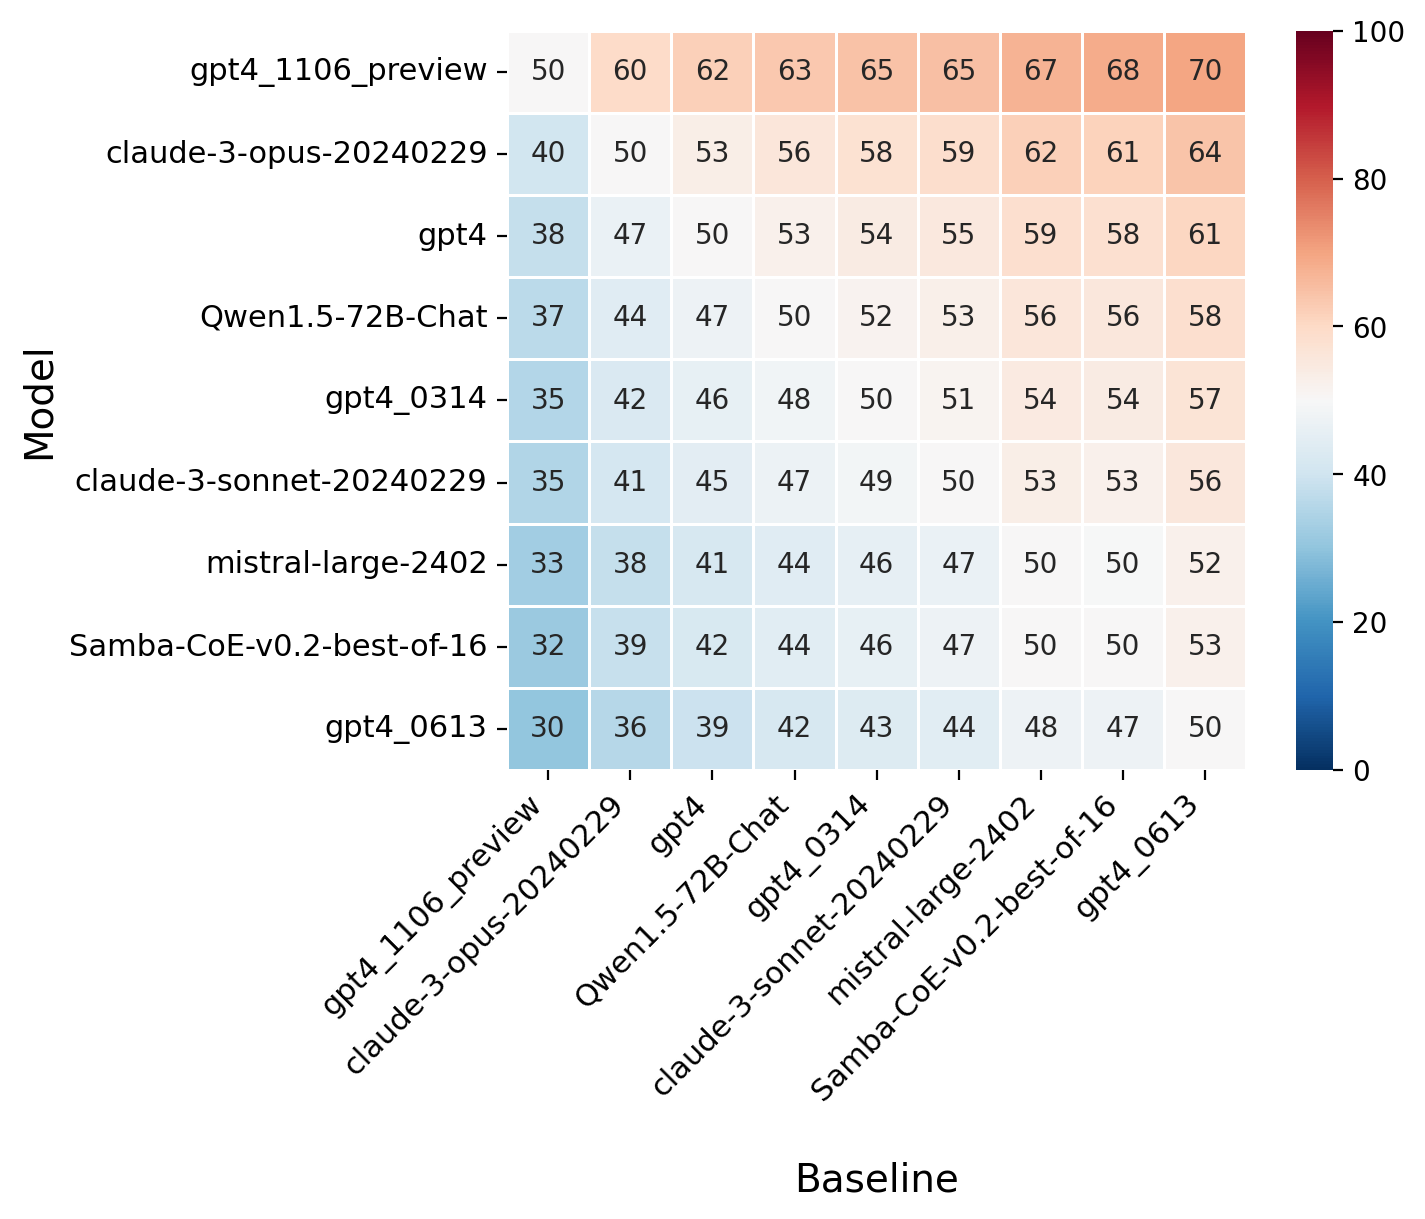

In [5]:
g = plot_heatmap_diff_baseline(models)

In [6]:
save_fig(g, filename="figures/different_baselines.png")

# Annotator bias

One other important bias with AlpacaEval is that the auto annotator might be biased towards itself or models trained on its outputs. Let's see if that is indeed a major issue.

In [15]:
from alpaca_eval import utils
lb_turbo4 = utils.load_or_convert_to_dataframe(constants.ALPACAEVAL_2_LEADERBOARD_PATHS/ f"weighted_alpaca_eval_gpt4_turbo_leaderboard.csv")
lb_opus = utils.load_or_convert_to_dataframe(constants.ALPACAEVAL_2_LEADERBOARD_PATHS/ f"claude_3_opus_ranking_leaderboard.csv")
lb_mistral = utils.load_or_convert_to_dataframe(constants.ALPACAEVAL_2_LEADERBOARD_PATHS/ f"mistral-large-2402_ranking_leaderboard.csv")
model_lb = {"gpt4_1106_preview":lb_turbo4, "claude-3-opus-20240229": lb_opus, "mistral-large-2402": lb_mistral}
rows = list(model_lb.keys()) + ["gpt4_0613", "gpt-3.5-turbo-1106"]
model_lcae = {k:v.loc[rows, "length_controlled_winrate"] for k,v in model_lb.items()}

In [21]:
styles = [
        {"selector": "thead tr:first-child th", "props": [("text-align", "center")]},
        {"selector": "thead tr:last-child th:last-child", "props": [("border-right", "none")]},
    ]

In [26]:
ann_bias_styles = pd.concat([pd.DataFrame(model_lcae)], keys=['Auto-annotator'], axis=1).style.format("{:.1f}").set_table_styles(styles)
ann_bias_styles

In [27]:
save_fig(ann_bias_styles, filename="figures/annotator_bias.png")

# Regularization

One important thing we tried to avoid is gameability of the new metric. We did that by adding regularization. Here we can see the performance of a gamed model with and without regularization. Note that regularization makes little difference for statndard models.

In [13]:
from alpaca_eval.metrics.glm_winrate import get_length_controlled_winrate

In [14]:
gamed_annotations = pd.read_json("results/gpt4_gamed/weighted_alpaca_eval_gpt4_turbo/annotations.json")

In [15]:
for lmbda in [None, 0.2, 0.5]:

    metrics = get_length_controlled_winrate(
        annotations=gamed_annotations,
        glm_name="length_controlled_v1_noreg",
        save_weights_dir=None,
        glm_info={
            "formula": "np.tanh(std_delta_len) + instruction_difficulty + not_gamed_baseline.astype(float) - 1",
            "regularize_to_baseline_lambda": lmbda,
            "kwargs": {"n_splits": 5},
        },
    )

    print(f"LC win rate for {lmbda} is {metrics['length_controlled_winrate']:.1f}.")
print(f"Win rate is {metrics['win_rate']:.1f}.")

LC win rate for None is 25.9.
LC win rate for 0.2 is 12.2.
LC win rate for 0.5 is 9.9.
Win rate is 3.7.
